# Python

In [126]:
import numpy as np
import pandas as pd

import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as smp

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Задача 2 Списки чисел

In [149]:
#заметим что с mean, min и  max  мы делаем одно и то же

def lists_of_numbers(list1, list2):
    return tuple(map(lambda func: 'First' if func(list1) < func(list2)\
                 else 'Second' if func(list2) < func(list1) else 'Equal',\
                 [np.mean, np.min, np.max]))

In [150]:
lists_of_numbers([1, 2, 3], [2, 2, 2])

('Equal', 'First', 'Second')

##  Задача 1 A/B тест

In [134]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [135]:
metrics = df.groupby('VARIANT_NAME', as_index=False).agg({'USER_ID' : 'count',
                                                          'REVENUE' : lambda column: (column != 0).sum()})
metrics['conversion'] = round(metrics['REVENUE']/metrics['USER_ID'] * 100, 2)
metrics

,VARIANT_NAME,USER_ID,REVENUE,conversion
0,control,4984,80.0,1.61
1,variant,5016,72.0,1.44


Будем использовать критерий Хи-квадрат для конверсии

In [136]:
alpha = 0.05
chi2stat, pval, table = proportion.proportions_chisquare(metrics['REVENUE'], metrics['USER_ID'])
print(pval < alpha)

False


Статистически значимой разницы в конверсии не обнаружено, так как p-value выше выбранного порога ошибки первого рода

Посмотрим также средний чек. Используем метод Bootstrap

In [137]:
test_group = df[df['VARIANT_NAME'] == 'variant']['REVENUE'].dropna().values
control_group = df[df['VARIANT_NAME'] == 'control']['REVENUE'].dropna().values

In [138]:
boot_results = bs.bootstrap_ab(test=test_group, ctrl=control_group,\
                                stat_func=bs_stats.mean,\
                                compare_func=bs_compare.difference,\
                                return_distribution=True)

In [139]:
borders = np.percentile(boot_results, [2.5, 97.5])

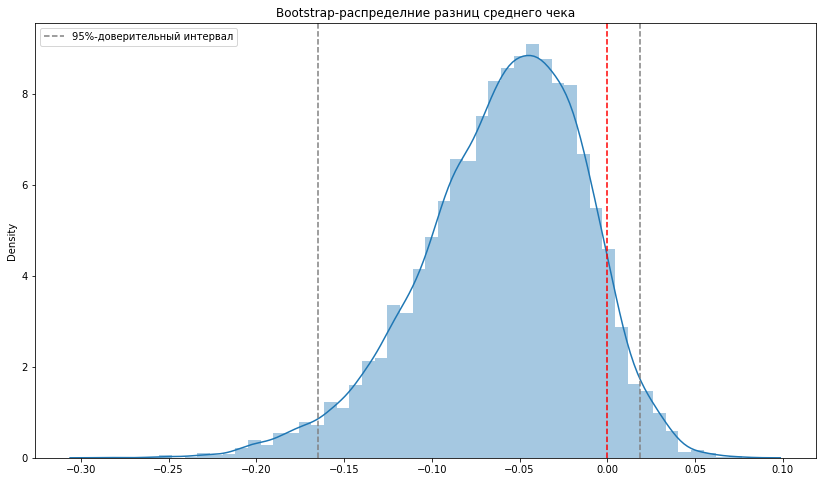

In [140]:
plt.figure(figsize=(14,8))
sns.distplot(boot_results)
plt.title('Bootstrap-распределние разниц среднего чека')
# plt.rcParams['figure.figsize'] = (14, 8)
# plt.vlines(0, ymin = 0, ymax = 0.003, linestyles = '--', colors = 'red')
# plt.vlines(borders, ymin = 0, ymax = 0.003, linestyles = '--', colors = 'gray', label = '95%-доверительный интервал')
plt.axvline(0, linestyle = '--', color = 'red')
plt.axvline(borders[0], linestyle = '--', color = 'gray')
plt.axvline(borders[1], linestyle = '--', color = 'gray', label = '95%-доверительный интервал')
plt.legend()
plt.show()

Как мы видим, в наш доверительный интервал входит значение 0, а это значит, что статистически значимой разницы в среднем чеке мы также не обнаруживаем

Вычислим мощность при использовании критерия Хи-квадрат

In [141]:
chipower = smp.GofChisquarePower()

In [142]:
conversion_control = metrics['conversion'].values[0]/100
conversion_test = metrics['conversion'].values[1]/100
nobs = min(metrics['USER_ID'])

In [143]:
def chi2_effect_size(p0, p1):
    return np.sqrt((p0 - p1) ** 2 / p0)

In [144]:
chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test),\
                     nobs = nobs, alpha = pval, power = None)

0.6501212390641966

Мощность достаточно низкая: с вероятностью более чем 34% мы бы не увидели статистически значимых отличий там, где они существуют. Стандартным значением мощности является 80% и выше.

Вычислим количество наблюдений, необходимых для получения желаемого уровня мощности 

In [145]:
power = 0.8

In [148]:
size_of_each_test_group = chipower.\
solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test),\
            nobs = None, alpha = alpha, power = power)
print('Необходимый размер выборки для эксперимента - {:.0f}'.format(2 * size_of_each_test_group))

Необходимый размер выборки для эксперимента - 87451


Какой вывод мы можем сделать: надо увеличить время наблюдений, чтобы набрать большую выборку

Некоторые замечания:
- Можно добавить данные, чтобы закрыть конверсионные окна: так например, у пользователей, которые заходили в последние дни тестирования, было меньше времени, чтобы воспользоваться услугами сайта, и из данных неизвестно учтен ли этот фактор, также никак не учитываются данные пользователя: например является ли он постоянным клиентом или же первый раз зашел на сайт, к какой целевой аудитории принадлежит тот или иной пользователь; в зависимости от того, какие услуги предоставляет сайт, можно накинуть еще ряд метрик 

Рекомендации менеджеру:
- С учетом того, что мощность достаточно низкая, я бы предложил продолжить тестирование, чтобы набрать больше данных
- Если же исходить из тех данных, которые есть, и проведенного анализа (Хи-квадрат для конверсии и Bootstrap для среднего чека) можно сделать вывод, что статистически значимой разницы между контрольной и тестовой выборкой нет

# SQL

Verion of SQL: MySQL

In [ ]:
----SQL Задача 1
----Оцените на каждый день количество просмотров отдельно по монетизациям SVOD и AVOD на платформах 10 и 11 за последние 30 дней.

SELECT show_date, SUM(CASE paid_type WHEN 'SVOD' THEN 1 ELSE NULL END) AS views_svod,
SUM(CASE paid_type WHEN 'AVOD' THEN 1 ELSE NULL END) AS views_avod
FROM
(SELECT cw.show_date AS show_date, cw.platform AS platform, c.paid_type AS paid_type
FROM content_watch as cw, content as c
WHERE cw.content_id=c.content_id 
AND (cw.platform = 10 OR cw.platform = 11)
ORDER BY cw.show_date DESC LIMIT 30)
GROUP BY show_date;

In [ ]:
----SQL Задача 3
----Используя таблицы выше, напишите следующие SQL запросы:
----Для каждого сотрудника найти его департамент, включая тех, у кого департамента нет:

SELECT Employees.name AS name, Departments.name AS department
FROM Employees LEFT OUTER JOIN Departments
ON Employees.Dep_id = Departments.id;

----Найти наибольшую зарплату по департаментам и отсортировать департаменты по убыванию максимальной зарплаты

SELECT MAX(salary) AS max_salary, department 
FROM
(SELECT Employees.Salary AS salary, Departments.name AS department
FROM Employees LEFT OUTER JOIN Departments
ON Employees.Dep_id = Departments.id)
GROUP BY department
ORDER BY MAX(salary) DESC;

----Посчитать среднюю зарплату команды в группировке по менеджерам. (в таблице Employees Manager_id!=id)

SELECT AVG(Salary) AS average_salary, Manager_id
FROM Employees
GROUP BY Manager_id;

# Бизнесовая задача

Придумайте, как оценить показатель «Рекламная нагрузка».

Нужна метрика, которая позволит оценить, с каким объемом рекламы сталкивается пользователь главной мейла при потреблении контента (публикации и видео).

В каких показателях оценить эту метрику. Какой подход можно использовать чтобы оценить величину нагрузки – приемлемая или слишком высокая.

Написание запроса не обязательно, необходим сам подход к расчету, формула, список данных, которые понадобятся. Представьте, что ограничений в данных нет.

![alt text](mail_main.png "Title")

Будем рассчитывать коэффициент рекламной нагрузки, как отношение количества рекламы просмотренной пользователем к общему времени, которое он провел на странице:

коэффициент рекламной нагрузки = количество рекламы / общее время, которое пользователь провел на странице в данную сессию

Давайте подумаем, как оптимально рассчитать  параметр количество рекламы. 
Предлагаю производить расчет с весами:

количество рекламы = sum_i( вес_i * реклама_i )

Параметр реклама_i - это то, сколько раз пользователь видит одно и то же рекламное объявление/видеоролик на странице,
то есть, например, если на странице одно рекламное объявление, то реклама_i = 1.

В свою очередь вес_i будет зависеть от ряда параметров:
- будем исходить из того, что у нас есть разные виды рекламы -  
публикации, реклама во время видео и т.д. Так например, если мы знаем, что пользователь скорее обратит внимание на рекламу во время видео, чем на текстовое объявление, то вес видеорекламы больше

- также учтем, что есть реклама, которую можно перемотать/закрыть, и 
соответственно реклама, которую пользователь закрыть не может. Если пользователь начинает закрывать рекламу - это может свидетельствовать о том, что он или устал от рекламы (она стала слишком навязчивой, мешает наслаждаться контентом) или он просто не является целевой аудиторией для данной рекламы и она ему не интересна. Прежде чем расписывать данную бизнесовую задачу, я сам зашел на главную страницу мейла, чтобы попробовать, потыкать, посмотреть и обнаружил, что у рекламы, которую можно закрыть, всплывает окошко с опросом, касательно причин закрытия. Будем учитывать в весе возможность (или ее отстутсвие) у пользователя закрыть рекламу.

![alt text](mail_main2.png "Title")

- также будем учитывать время, которое пользователь провел на той части страницы, где размещена реклама, чем больше времени он там провел, тем больше соответсвенно будет вес

- учтем положение рекламы на сайте: чем выше она размещена, тем больше шанс, что пользователь ее впринипе заметит

- для постоянных пользователей, для которых мы знаем поисковую историю, чем они интересуются, к какой целевой аудитории принадлежат,
реклама может быть таргетированной, и то является ли реклама таргетированной также должно учитываться в весе

- также надо учесть расположение объявлений/банеров в кокретной области страницы, попадают ли объявления в область баннерной слепоты (30-40% объявлений пользоваетли вообще не замечают) 

Сама по себе функция вес_i может выглядеть по разному, но она в любом случае должна учитывать ряд параметров описанных выше, и задавать 'важность' того или иного рекламного объявления.

Теперь давайте зададимся следующим вопросом: в каком случае мы будем считать величину нагрузки приемлимой, а в каком слишком высокой?

Для того, чтобы определить значение коэффициента рекламной нагрузки, которое является приемлимым, предлагаю провести исследование - предложить разным группам пользователей тестовые версии сайта с разным количеством рекламы и определить некоторое оптимальное ее количество, при котором пользователь проводит как можно больше времени на сайте, как можно дальше (ниже) продвинется по странице и как можно меньше закрывает рекламные объявления, подобное же исследование может помочь оптимальное расположение баннеров. Так если реклама будет в самом центре страницы, то это будет мешать пользователем и мы увидим это во время тестирования.

После исследования, зная оптимальный показатель коэффициента рекламной нагрузки, оптимальное расположение объявлений и баннеров мы можем наилучшим способом разместить рекламу на странице: так и пользователь останется доволен и мы, как владельцы сайта!
